In [2]:
import sys
import os

SCRIPT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
DATA_PATH = os.path.join(SCRIPT_DIR,'data')
sys.path.append(SCRIPT_DIR)

import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm

from scipy.special import logsumexp
from scipy import stats

import numpy as np

from bocpd import bocpd
from hazard import ConstantHazard
from models import GaussianUnknownMean, GaussianUnknownMeanVariance
from models import SMGaussianUnknownMean, DSMGaussianUnknownMean, DSMGaussianSampling, DSMGaussianApprox 
from generate_data import generate_data
from beta_estimator import BetaEstimatorFisher, BetaEstimatorKL


from plot import plot_posterior

# synthetic dataset

In [3]:
np.random.seed(4574)

T      = 2000 # Number of observations.
hazard = ConstantHazard(400)
mean0  = 0      # The prior mean on the mean parameter.
var0   = 5 
# The prior variance for mean parameter.
varx   = 1      # The known variance of the data.

data, cps  = generate_data(varx, mean0, var0, T, hazard)
data = np.array(data)
#contamination = np.random.choice(np.arange(T),size=20)
#data[contamination] = data[contamination] + np.random.normal(loc=0,scale=60)


# Known Variance

### BOCPD

In [4]:
model  = GaussianUnknownMean(mean0, var0, varx)

In [5]:
%%time
R_BOCP  = bocpd(data, hazard, model)

CPU times: user 1.93 s, sys: 16.5 ms, total: 1.95 s
Wall time: 1.97 s


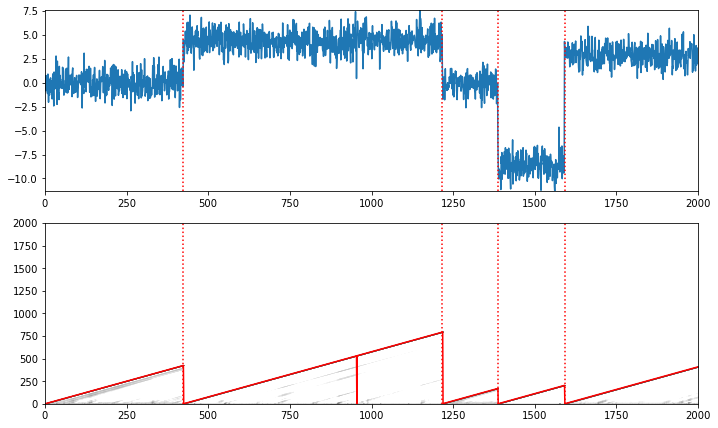

In [6]:
plot_posterior(T, data, R_BOCP, cps)

### SM-BOCPD

In [7]:
def grad_t(x):
    return np.eye(1)/varx

def grad_b(x):
    return -x/varx

def lap_t(x):
    return np.zeros(1)

data = np.array(data).reshape([T,1])
beta = 0.0001

model = SMGaussianUnknownMean(data, grad_t, lap_t, grad_b, beta, mean0, var0, varx)

In [8]:
%%time
R = bocpd(data, hazard, model)

CPU times: user 2.35 s, sys: 26.5 ms, total: 2.38 s
Wall time: 2.4 s


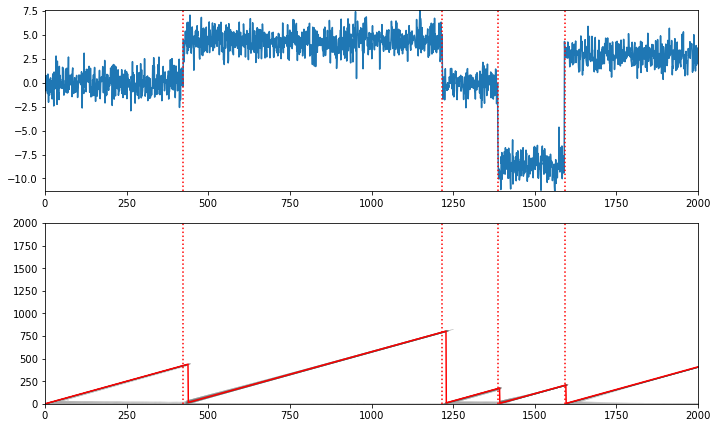

In [9]:
plot_posterior(T, data, R, cps)

### DSM-BOCPD

In [10]:
def m(x):
    return np.array([(1+x**2)**(-1/2)])

def grad_m(x):
    return np.array([[-x/((1+x**2)**(3/2))]])

def grad_t(x):
    return np.eye(1)/varx

def grad_b(x):
    return -np.array([x])/varx

def hess_t(x):
    return np.zeros([1,1,1])

data = np.array(data).reshape([T,1])
beta = 0.01
model = DSMGaussianUnknownMean(data,m ,grad_m, grad_t, hess_t, grad_b, beta, mean0, var0, varx)

In [11]:
%%time
R  = bocpd(data, hazard, model)

CPU times: user 2.67 s, sys: 22.9 ms, total: 2.69 s
Wall time: 2.7 s


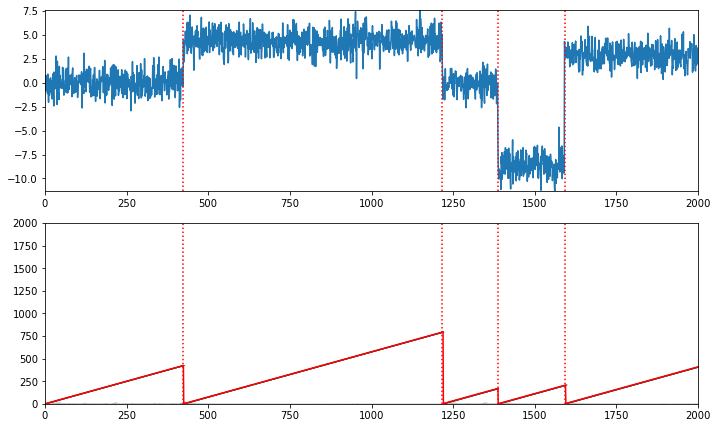

In [12]:
plot_posterior(T, data, R, cps)

# Gaussian

### BOCP

In [13]:
model  = GaussianUnknownMeanVariance(mean0, 1/var0, 1, 1)

In [14]:
%%time
R  = bocpd(data, hazard, model)

CPU times: user 732 ms, sys: 3.37 ms, total: 735 ms
Wall time: 744 ms


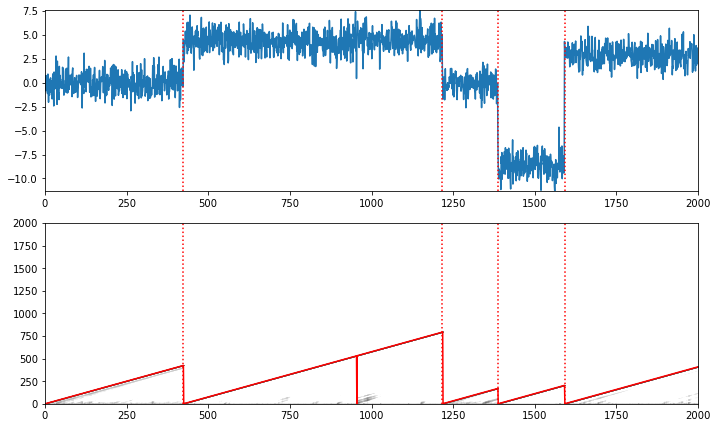

In [15]:
plot_posterior(T, data, R, cps)

### DSM-BOCPD Sampling

In [17]:
def m(x):
    return np.asarray([(1+x**2)**(-1/2)])

def grad_m(x):
    return np.asarray([[-x/((1+x**2)**(3/2))]])

def grad_t(x):
    return np.asarray([[1,-x]],dtype='float')

def grad_b(x):
    return np.array([[0]])

def hess_t(x):
    return np.array([[[0,-1]]])

data = np.array(data).reshape([T,1])
beta = 0.5

mu0 = np.array([[0], [1]])
Sigma0 = np.eye(2)
Sigma0[0,0] = 5
Sigma0[1,1] = 0.2

model = DSMGaussianSampling(data,m ,grad_m, grad_t, hess_t, grad_b, beta, mu0, Sigma0, b = 10)

In [19]:
%%time
R  = bocpd(data, hazard, model, K=50, verbose = True)

Processing observation #100
Processing observation #200
Processing observation #300
Processing observation #400
Processing observation #500
Processing observation #600
Processing observation #700
Processing observation #800
Processing observation #900
Processing observation #1000
Processing observation #1100
Processing observation #1200
Processing observation #1300
Processing observation #1400
Processing observation #1500
Processing observation #1600
Processing observation #1700
Processing observation #1800
Processing observation #1900
Processing observation #2000
CPU times: user 4min 22s, sys: 305 ms, total: 4min 23s
Wall time: 4min 24s


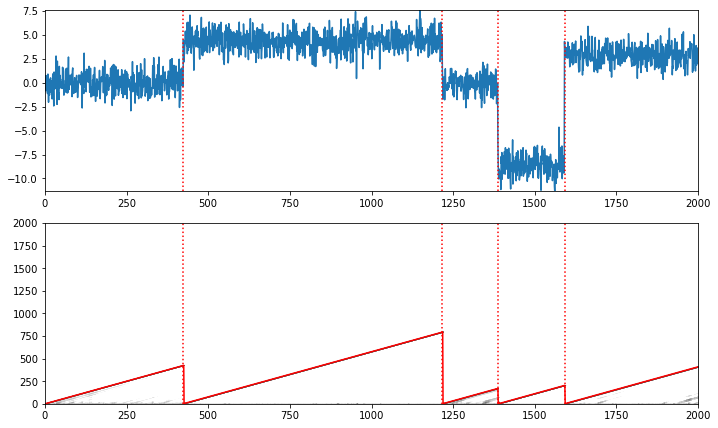

In [20]:
plot_posterior(T, data, R, cps)

### DSM-BOCPD t - Approximation

In [22]:
def m(x):
    return np.asarray([(1+x**2)**(-1/2)])

def grad_m(x):
    return np.asarray([[-x/((1+x**2)**(3/2))]])

def grad_t(x):
    return np.asarray([[1,-x]],dtype='float')

def grad_b(x):
    return np.asarray([[0]])

def hess_t(x):
    return np.asarray([[[0,-1]]])

data = np.array(data).reshape([T,1])
beta = 0.1

mu0 = np.array([[0], [1]])
Sigma0 = np.eye(2)
Sigma0[0,0] = 1
Sigma0[1,1] = 1

model = DSMGaussianApprox(data,m ,grad_m, grad_t, hess_t, grad_b, beta, mu0, Sigma0)

In [25]:
%%time
R  = bocpd(data, hazard, model, K=50, verbose=True)

Processing observation #100
Processing observation #200
Processing observation #300
Processing observation #400
Processing observation #500
Processing observation #600
Processing observation #700
Processing observation #800
Processing observation #900
Processing observation #1000
Processing observation #1100
Processing observation #1200
Processing observation #1300
Processing observation #1400
Processing observation #1500
Processing observation #1600
Processing observation #1700
Processing observation #1800
Processing observation #1900
Processing observation #2000
CPU times: user 3min 4s, sys: 269 ms, total: 3min 5s
Wall time: 3min 7s


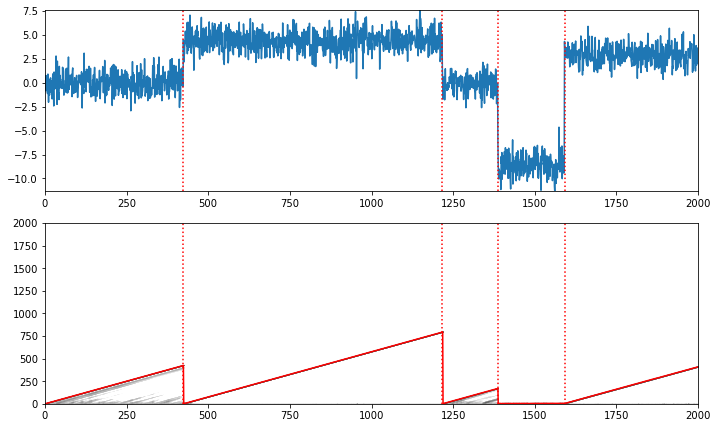

In [26]:
plot_posterior(T, data, R, cps)